In [1]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

from utils import GraphGenerator

erdos_renyi_graph = GraphGenerator.erdos_renyi_generator(n=10, p=0.1)  # Example parameters
waxman_graph = GraphGenerator.waxman_generator_1(n=10, alpha=0.1, beta=0.1)  # Example parameters

graphs = {
    'Erdos-Renyi': erdos_renyi_graph,
    'Waxman': waxman_graph
}

number_of_flows = [i for i in range(0, 101, 10)]

Evaluating edge 1,2
Evaluating edge 1,3
Evaluating edge 1,4
Evaluating edge 1,5
Evaluating edge 1,6
Evaluating edge 1,7
Evaluating edge 1,8
Evaluating edge 1,9
Evaluating edge 1,10
Evaluating edge 2,3
Evaluating edge 2,4
Evaluating edge 2,5
Evaluating edge 2,6
Evaluating edge 2,7
Evaluating edge 2,8
Evaluating edge 2,9
Evaluating edge 2,10
Evaluating edge 3,4
Evaluating edge 3,5
Evaluating edge 3,6
Evaluating edge 3,7
Evaluating edge 3,8
Evaluating edge 3,9
Evaluating edge 3,10
Evaluating edge 4,5
Evaluating edge 4,6
Evaluating edge 4,7
Evaluating edge 4,8
Evaluating edge 4,9
Evaluating edge 4,10
Evaluating edge 5,6
Evaluating edge 5,7
Evaluating edge 5,8
Evaluating edge 5,9
Evaluating edge 5,10
Evaluating edge 6,7
Evaluating edge 6,8
Evaluating edge 6,9
Evaluating edge 6,10
Evaluating edge 7,8
Evaluating edge 7,9
Evaluating edge 7,10
Evaluating edge 8,9
Evaluating edge 8,10
Evaluating edge 9,10


In [2]:
def generate_random_flows(graph: nx.Graph, m: int) -> dict[int, [int]]:
    flows = {}
    flow_set = set()  # deduplicate
    nodes = list(graph.nodes())  # Assume nodes are already integers or convertible to integers
    while len(flow_set) < m:
        source = random.choice(nodes)
        target = random.choice([node for node in nodes if node != source])
        paths = list(nx.all_simple_paths(graph, source=source, target=target))
        if paths:
            selected_path = random.choice(paths)
            converted_path = (int(node) for node in selected_path)
            flow_set.add(converted_path)
    for index, flow in zip(range(m), flow_set):
        flows[index] = list(flow)

    return flows

In [3]:
def generate_switch_flow_list(flows) -> dict[int, [int]]:
    switch_flow_dict = {}

    for flow_id, switches in flows.items():
        for switch_id in switches:
            switch_id = int(switch_id)
            switch_flow_dict.setdefault(switch_id, set()).add(flow_id)

    return {switch_id: list(flow_ids) for switch_id, flow_ids in switch_flow_dict.items()}

In [4]:
from utils.SetCover import set_cover_solve

def calculate_naive_cost(graph, flows):
    # Each request is 122 bytes and each reply is 174 bytes
    request_size = 122
    reply_size = 174
    total_cost = 0

    for flow in flows.values():
        total_cost += request_size + reply_size

    return total_cost

results = []

def calculate_optimized_cost(flow_ids, switch_flow_list):
    optimized_set = set_cover_solve(flow_ids, switch_flow_list)
    total_cost = 0
    
    for switch_id, flows in optimized_set.items():
        total_cost += 122 + 78 + 96 * len(flows)
        
    return total_cost

for name, graph in graphs.items():
    for flow_count in number_of_flows:
        flows = generate_random_flows(graph, flow_count)
        flow_ids = list(flows.keys())
        switch_flow_list = generate_switch_flow_list(flows)
        
        naive_cost = calculate_naive_cost(graph, flows)
        optimized_cost = calculate_optimized_cost(flow_ids, switch_flow_list)
        results.append({
            'Graph': name,
            'Number of Flows': flow_count,
            'Naive Cost': naive_cost,
            'Optimized Cost': optimized_cost
        })

All flows have been successfully covered.
Picked switch 8 covering flows {0, 1, 2, 3, 4, 5, 6, 7, 8, 9} with ratio 90.2.
All flows have been successfully covered.
Picked switch 3 covering flows {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18} with ratio 84.42105263157895.
Randomly picked switch 8 for single flow 19 due to high ratio or no better option.
All flows have been successfully covered.
Picked switch 3 covering flows {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 23, 24, 26, 28, 29} with ratio 82.88.
Randomly picked switch 7 for single flow 27 due to high ratio or no better option.
Randomly picked switch 7 for single flow 25 due to high ratio or no better option.
Randomly picked switch 8 for single flow 21 due to high ratio or no better option.
Randomly picked switch 8 for single flow 17 due to high ratio or no better option.
Randomly picked switch 8 for single flow 19 due to high ratio or no better option.
All flows have been successfu

# Save Results to CSV

In [5]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
filename = f"data/flow_stats_{timestamp}.csv"

# Ensure the stats directory exists
os.makedirs(os.path.dirname(filename), exist_ok=True)

# Convert results to DataFrame and save as CSV
df = pd.DataFrame(results)
df.to_csv(filename, index=False)

print(f"Results saved to {filename}")

Results saved to data/flow_stats_20240611-204302.csv


# Plot the Graph

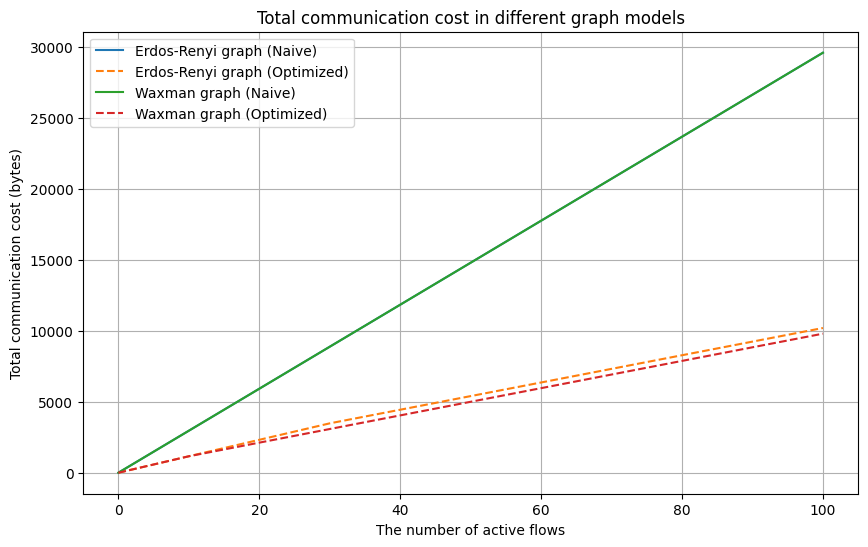

In [7]:
# Plot the graph
df = pd.read_csv(filename)

plt.figure(figsize=(10, 6))
for graph in df['Graph'].unique():
    graph_df = df[df['Graph'] == graph]
    plt.plot(graph_df['Number of Flows'], graph_df['Naive Cost'], label=f'{graph} graph (Naive)')
    plt.plot(graph_df['Number of Flows'], graph_df['Optimized Cost'], label=f'{graph} graph (Optimized)', linestyle='--')

plt.xlabel('The number of active flows')
plt.ylabel('Total communication cost (bytes)')
plt.title('Total communication cost in different graph models')
plt.legend()
plt.grid(True)
plt.show()